In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install Unidecode
import unidecode
import numpy as np
from ipywidgets import interact, widgets

AUTH_KEY = 'ckyzfbq1yzKH1uGEn9fnVzrFlz789QmPBWd7WzsG'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.4 MB/s eta 0:00:00


### <strong>Conectividad al servicio de Internet</strong>

Consulta las tecnologías disponibles en tu localidad para acceder al servicio de Internet fijo y móvil

La población total según el censo llevado es: 37484525 habitantes 



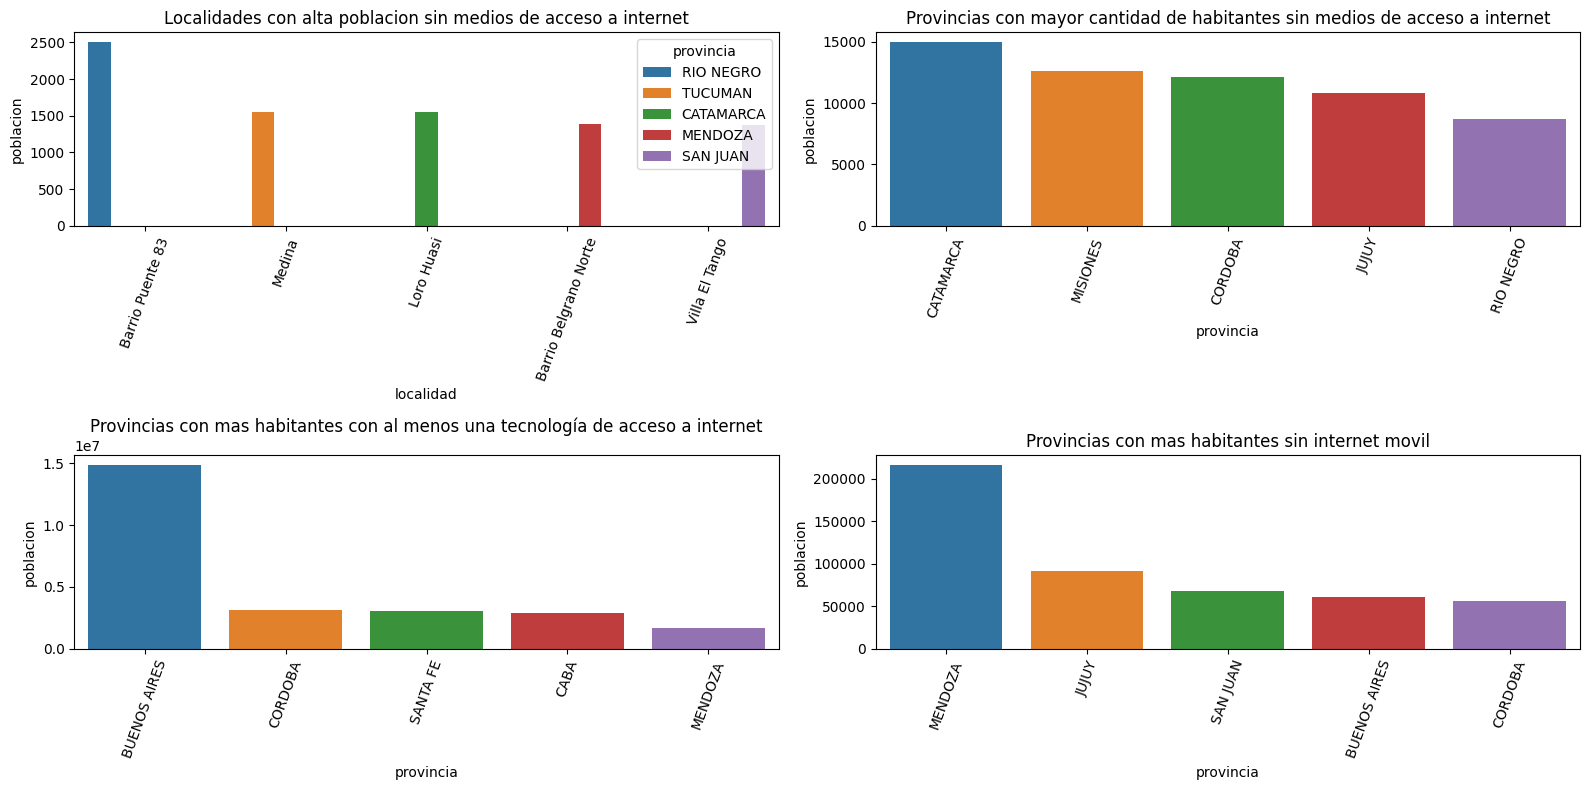

,provincia,poblacion,adsl,cablemodem,dial_up,fibra_optica,satelital,wireless,telefonia_fija,3g,4g,totalTech_byLoc
0,CATAMARCA,343343,7,1,1,23,47,34,56,29,57,255


In [2]:
### Se extrae el data set desde la API ###
respuesta_API_listaxloc = requests.get(
    'http://api.datosabiertos.enacom.gob.ar/api/v2/datastreams/CONEC-AL-SERVI-DE-INTER/data.ajson/?auth_key='+AUTH_KEY
)
##########################################

if respuesta_API_listaxloc.status_code == 200:
  data = respuesta_API_listaxloc.text
  parse_json = json.loads(data)
  listaxloc = pd.read_json(json.dumps(parse_json['result']))      #Se carga el dataset en un DataFrame
  listaxloc.columns = listaxloc.loc[0]                            #Se establece el nombre de las columnas
  listaxloc.columns = list(map(lambda x: unidecode.unidecode(x.replace(' ', '_').lower()), listaxloc.columns))    #Se reemplazan los espacios por guiones bajo en los nombres de la columna
  listaxloc = listaxloc.drop(0)                                   #Se elimina la fila que contiene los nombres de las columnas originalmente
  listaxloc = listaxloc.drop(columns=['link'])                    #Se elimina una columna innecesaria
  listaxloc.reset_index(drop=True, inplace=True)                  #Se resetean los indices
else:
  listaxloc = pd.read_csv('calsinter.csv')
  listaxloc.columns = list(map(lambda z: unidecode.unidecode(z.replace(' ', '_').lower()), listaxloc.columns))
  listaxloc = listaxloc.drop(columns=['link'])
  listaxloc.reset_index(drop=True, inplace=True)

### Se reemplazan comas por puntos para manejar valores numericos ###
listaxloc['latitud'] = listaxloc['latitud'].apply(lambda string: string.replace(',', '.'))
listaxloc['longitud'] = listaxloc['longitud'].apply(lambda string: string.replace(',', '.'))
#####################################################################

### Se cambia el string 'SI' por unos y '--' por ceros ###
listaxloc[['adsl', 'cablemodem', 'dial_up', 'fibra_optica', 'satelital',	'wireless', 'telefonia_fija', '3g', '4g']] = listaxloc[
    ['adsl', 'cablemodem', 'dial_up', 'fibra_optica', 'satelital',	'wireless', 'telefonia_fija', '3g', '4g']
].apply(lambda string: string.replace('SI', '1'))
listaxloc[['adsl', 'cablemodem', 'dial_up', 'fibra_optica', 'satelital',	'wireless', 'telefonia_fija', '3g', '4g']] = listaxloc[
    ['adsl', 'cablemodem', 'dial_up', 'fibra_optica', 'satelital',	'wireless', 'telefonia_fija', '3g', '4g']
].apply(lambda string: string.replace('--', '0'))
##########################################################

### Se cambia el tipo de datos de algunas columnas ###
listaxloc = listaxloc.astype(
    {
        'poblacion': 'int',
        'adsl': 'int',
        'cablemodem': 'int',
        'dial_up': 'int',
        'fibra_optica': 'int',
        'satelital': 'int',
        'wireless': 'int',
        'telefonia_fija': 'int',
        '3g': 'int',
        '4g': 'int',}
)

listaxloc.drop(columns=['partido'], inplace=True)       #Se elimina la columna partido

### Se calcula el total de tecnologias por localidad ###
listaxloc['totalTech_byLoc'] = listaxloc[['adsl', 'cablemodem', 'dial_up', 'fibra_optica', 'satelital',	'wireless', 'telefonia_fija', '3g', '4g']].apply(lambda x: sum(x.values), axis=1)
########################################################

### Obtenemos un DataFrame donde cada localidad tenga al menos 1 tecnologia de acceso a internet ###
allTech_byProv = listaxloc[listaxloc['totalTech_byLoc']>0].groupby(by='provincia', as_index=False).sum(numeric_only=True).sort_values(by='poblacion', ascending=False)

#Calculamos el numero total de habitantes en el pais segun este censo
print(
    f"La población total según el censo llevado es: {listaxloc['poblacion'].sum()} habitantes \n"
)

### Realizamos las graficas correspondientes ###
fig, axes = plt.subplots(2, 2, figsize=(16,8), dpi=100)
sns.barplot(
    ax=axes[0,0],
    data=listaxloc[listaxloc['totalTech_byLoc']==0].nlargest(5, columns='poblacion'),
    y='poblacion', x='localidad', hue='provincia'
)
axes[0,0].set_title('Localidades con alta poblacion sin medios de acceso a internet')
axes[0,0].tick_params(axis='x', rotation=70)

sns.barplot(
    ax=axes[0,1],
    data=listaxloc[listaxloc['totalTech_byLoc']==0].groupby(by='provincia', as_index=False).sum(numeric_only=True).nlargest(5, columns='poblacion'),
    y='poblacion', x='provincia'
)
axes[0,1].set_title('Provincias con mayor cantidad de habitantes sin medios de acceso a internet')
axes[0,1].tick_params(axis='x', rotation=70)

sns.barplot(ax=axes[1,0], data=allTech_byProv.nlargest(5, columns='poblacion'), y='poblacion', x='provincia', )
axes[1,0].set_title('Provincias con mas habitantes con al menos una tecnología de acceso a internet')
axes[1,0].tick_params(axis='x', rotation=70)

sns.barplot(
    ax=axes[1,1],
    data=listaxloc[(listaxloc['3g']==0)&((listaxloc['4g']==0))].groupby(by='provincia', as_index=False).sum(numeric_only=True).nlargest(5, columns='poblacion'),
    y='poblacion',
    x='provincia',
)
axes[1,1].set_title('Provincias con mas habitantes sin internet movil')
axes[1,1].tick_params(axis='x', rotation=70)

plt.tight_layout()
plt.show()

display(listaxloc[listaxloc['provincia']=='CATAMARCA'].groupby(by='provincia', as_index=False).sum(numeric_only=True).sort_values(by='poblacion', ascending=False))

listaxloc.to_csv('listaxloc.csv')

*   <strong>[Figura Arriba-Izquierda]</strong> Con el fin de abordar los problemas de conectividad en función del numero de habitantes de manera particular, el analísis realizado detalla que existen localidades con una relativa alta población (1000-2000 habitantes) que carecen de algún servicio de internet, si un estudio socioeconomico es llevado a cabo en estas localidades en el cual se detalle la viabilidad de poner en marcha un servicio de internet, se recomienda hacer la inversión para dar acceso a internet bien sea con capital estatal o privado.

*   <strong>[Figura Arriba-Derecha]</strong> Según este estudio la provincia que mas número de habitantes tiene en localidades sin acceso a internet es Catamarca como tambien lo detalla el siguiente [articulo](https://www.pagina12.com.ar/327631-catamarca-es-una-de-las-provincias-con-menor-indice-de-hogar). Puede ser visto que el internet satelital es una de las tecnologías mas utilizadas en esta provincia, como bien lo cataloga el articulo antes mencionado, la geografía (montañosa) del lugar dificulta el acceso a internet de los habitantes y visitantes.

*   <strong>[Figura Abajo-Izquierda]</strong> Las provincias mejor conectadas omitiendo en este caso Buenos Aires, sabiendo que es la capital del país y posee un gran cantidad de habitantes, le sigue Cordoba con mas localidades que poseen al menos una tecnologia de acceso a internet.

*   **[Figura Abajo-Derecha]** Se aprecia que el 13% de la población de Mendoza no tiene acceso a internet, teniendo en cuenta esto, se propone iniciar las gestiones para expandir tanto la red movil 4G y 3G hacia esas zonas que carecen de la teconología, lo cual supondría aumentar la cantidad de suscriptores y por lo tanto la ganancia a nivel de empresa.

### <strong>Penetración del Internet fijo por provincia (accesos por cada 100 hogares)</strong>

Penetración del servicio de Internet fijo (métrica: hogares)

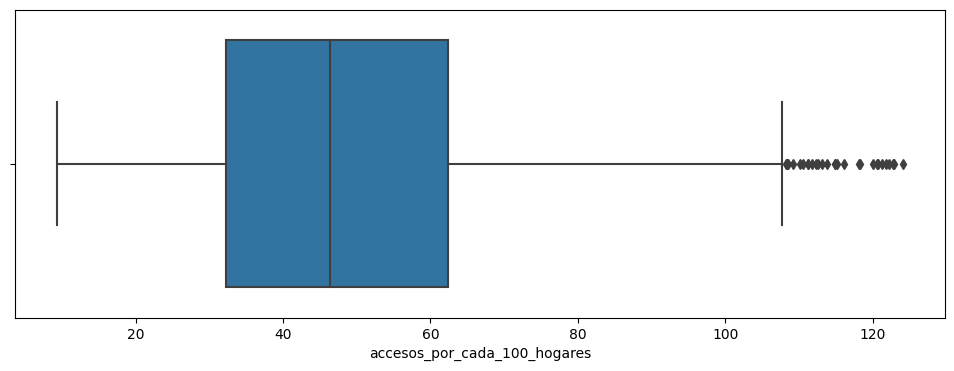

In [3]:
### Se extrae el data set desde la API ###
respuesta_API_penet_per100hog = requests.get(
    'http://api.datosabiertos.enacom.gob.ar/api/v2/datastreams/PENET-DEL-INTER-FIJO-51614/data.ajson/?auth_key='+AUTH_KEY
)
##########################################

if respuesta_API_penet_per100hog.status_code == 200:
  data = respuesta_API_penet_per100hog.text
  parse_json = json.loads(data)
  penet_per100hog = pd.read_json(json.dumps(parse_json['result']))      #Se carga el dataset en un DataFrame
  penet_per100hog.columns = penet_per100hog.loc[0]                      #Se establece el nombre de las columnas
  #Se reemplazan los espacios por guiones bajo en los nombres de la columna (Este procedimiento se realiza en las cargas posteriores)
  penet_per100hog.columns = list(map(lambda x: unidecode.unidecode(x.replace(' ', '_').lower()), penet_per100hog.columns))
  penet_per100hog = penet_per100hog.drop(0)                             #Se elimina la fila que contiene los nombres de las columnas originalmente (Este procedimiento se realiza en las cargas posteriores)
  penet_per100hog = penet_per100hog.drop(columns=[''])                  #Se eliminan columnas de valores vacios y nombres vacios
  penet_per100hog.reset_index(drop=True, inplace=True)                  #Se rsetean los indices (Este procedimiento se realiza en las cargas posteriores)
else:
  penet_per100hog = pd.read_csv('penp100hog.csv')
  penet_per100hog.columns = list(map(lambda z: unidecode.unidecode(z.replace(' ', '_').lower()), penet_per100hog.columns))
  penet_per100hog.dropna(axis=1, inplace=True)
  penet_per100hog.reset_index(drop=True, inplace=True)

### Cambiamos a mayusculas los nombres de provincias ###
penet_per100hog['provincia'] = penet_per100hog['provincia'].apply(lambda string: unidecode.unidecode(string.upper()))

### Cambiamos CAPITAL FEDERAL a CABA ###
penet_per100hog.loc[penet_per100hog['provincia']=='CAPITAL FEDERAL', 'provincia'] = 'CABA'

### Establecemos los valores de rango trimestral, ejemplo 1-2014 o bien 2-2022 ###
penet_per100hog['rango_trimestral'] = penet_per100hog['trimestre'] + '-' + penet_per100hog['ano']

### Cambiamos el tipo de dato a int ###
penet_per100hog['ano'] = penet_per100hog['ano'].apply(int)

### Cambiamos el tipo de dato a int ###
penet_per100hog['trimestre'] = penet_per100hog['trimestre'].apply(int)

### reemplazamos comas (,) por puntos (.) ###
penet_per100hog['accesos_por_cada_100_hogares'] = penet_per100hog['accesos_por_cada_100_hogares'].apply(lambda string: float(string.replace(',','.')))

### Calculamos la columna acceso previo, para cada trimestre ###
penet_per100hog['accesos_previo'] = penet_per100hog['accesos_por_cada_100_hogares'].shift(
    -len(penet_per100hog['provincia'].unique()),
)

### Calculamos el kpi_1  propuesto por Henry ###
penet_per100hog['kpi_1'] = ((penet_per100hog['accesos_por_cada_100_hogares'] - penet_per100hog['accesos_previo'])/penet_per100hog['accesos_previo'])*100

### Graficamos outliers
plt.figure(figsize=(12,4), dpi=100)
sns.boxplot(data=penet_per100hog, x='accesos_por_cada_100_hogares')

plt.show()
penet_per100hog.head()
penet_per100hog.to_csv('penet_per100hog.csv')

Estos valores fuera de los rangos intercuartiles no seran tomados como outliers. Queremos graficar tanto los mejores como los peores provincia con acceso a internet, para ellos determinamos usando pandad

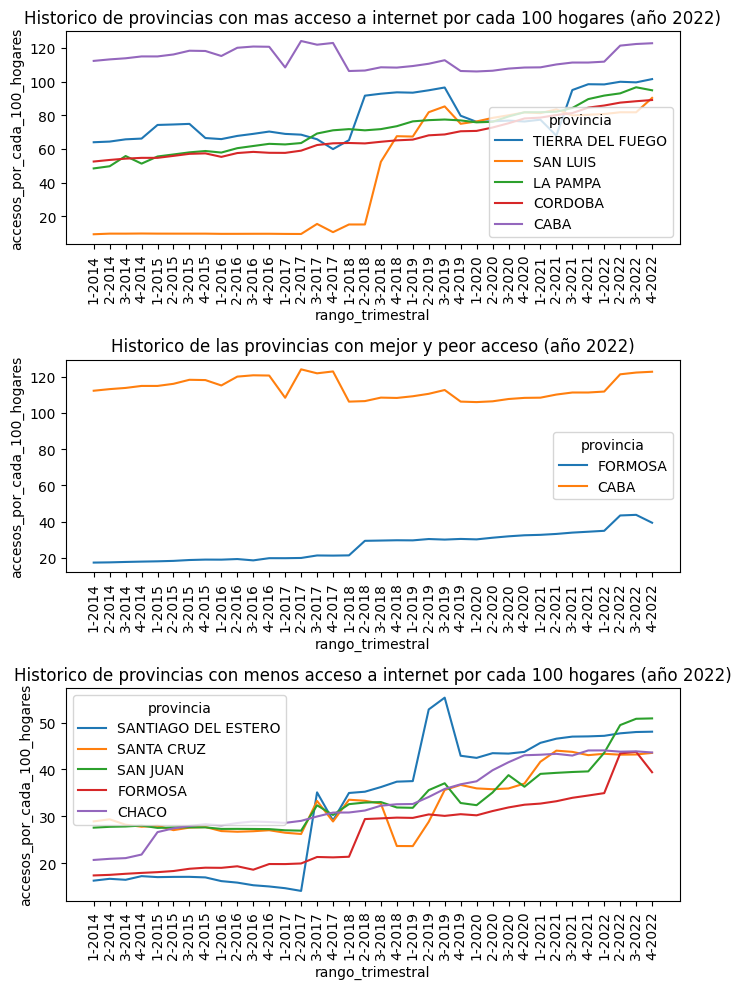

In [4]:
all = []
best_worst = []
title = [
    'Historico de provincias con mas acceso a internet por cada 100 hogares (año 2022)',
    'Historico de las provincias con mejor y peor acceso (año 2022)',
    'Historico de provincias con menos acceso a internet por cada 100 hogares (año 2022)'
]

# Hallamos la provincia con mejor acceso por hogares para el trimestre 4-2022
best_2022 = penet_per100hog[(penet_per100hog['ano']==2022) & (penet_per100hog['trimestre']==4)].nlargest(
    1,
    columns='accesos_por_cada_100_hogares'
)['provincia']
best_worst.append(str(*best_2022.values))   #Guardamos en la lista best_worst

# Hallamos la provincia con peor acceso por hogares para el trimestre 4-2022
worst_2022 = penet_per100hog[(penet_per100hog['ano']==2022) & (penet_per100hog['trimestre']==4)].nsmallest(
    1,
    columns='accesos_por_cada_100_hogares'
)['provincia']
best_worst.append(str(*worst_2022.values))    #Guardamos en la lista best_worst

# Hallamos las 5 provincia con peor acceso por hogares para el trimestre 4-2022
worst5_2022 = penet_per100hog[(penet_per100hog['ano']==2022) & (penet_per100hog['trimestre']==4)].nsmallest(
    5,
    columns='accesos_por_cada_100_hogares'
)['provincia']
worst5 = list(worst5_2022)    #Guardamos en la lista correspondiente

# Hallamos las 5 provincia con mejor acceso por hogares para el trimestre 4-2022
best5_2022 = penet_per100hog[(penet_per100hog['ano']==2022) & (penet_per100hog['trimestre']==4)].nlargest(
    5,
    columns='accesos_por_cada_100_hogares'
)['provincia']
best5 = list(best5_2022)    #Guardamos en la lista correspondiente

all.append(best5)
all.append(best_worst)
all.append(worst5)

# Graficamos el historico para cada provincia determinada
fig, axes = plt.subplots(3, figsize=(7,10), dpi=100)
for ax, plot_, title_ in zip(axes, all, title):
  sns.lineplot(
      ax=ax,
      data=penet_per100hog[penet_per100hog['provincia'].isin(plot_)].reindex(index=penet_per100hog.index[::-1]),
      y='accesos_por_cada_100_hogares',
      x='rango_trimestral',
      hue='provincia',
      markers=True,
      dashes=False
  )
  ax.tick_params(axis='x', rotation=90)
  ax.set_title(title_)
  plt.savefig(title_)
plt.tight_layout()
plt.show()

*   En las gráficas mostradas arriba es apreciable que en cada una de las provincia desde el dato inicial en el **año 2014** hasta el **año 2022** hay un crecimiento continuo, por lo cual se concluye que la inversión con el objetivo de aumentar el acceso a internet ha sido constante y ha dado frutos.

*   **[Primera gráfica]** Es notable el aumento de accesos mostrado por la provincia de **San Luis** (incremento del 700% de acceso desde 2014) que desde hace años [viene haciendo](https://www.telam.com.ar/notas/202305/628561-dia-mundial-internet-san-luis-pionera-conectividad-digital.html) inversiones significativas, ademas de hacer entrega de dispositivos digitales para el desarrollo tecnologico de la provincia. Este modelo de exito puede ser llevado a cabo en provincias de bajo acceso para así mejorar la calidad de vida del cuidadano.

*   **[Nota interesante]** Tierra dDel Fuego siendo una de las provincia mas al sur y alejada de la Argentina se presenta como un estandarte de acceso a internet por hogares.

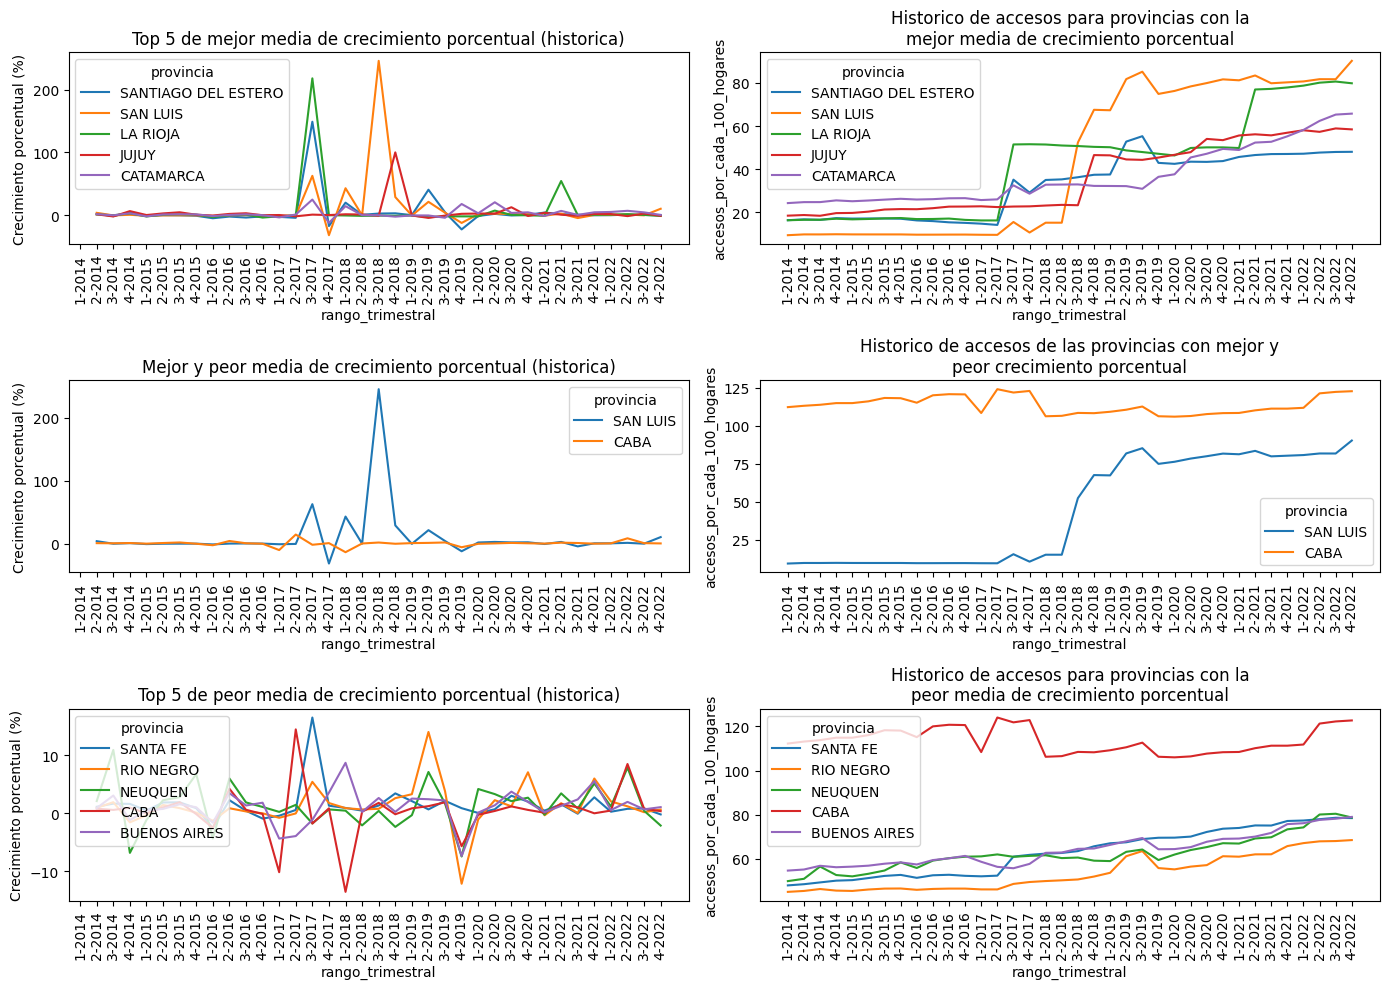

In [5]:
all = []
best_worst = []
title = [
    'Historico de accesos para provincias con la\nmejor media de crecimiento porcentual',
    'Historico de accesos de las provincias con mejor y\npeor crecimiento porcentual',
    'Historico de accesos para provincias con la\npeor media de crecimiento porcentual'
]
title_crecPorc = [
    'Top 5 de mejor media de crecimiento porcentual (historica)',
    'Mejor y peor media de crecimiento porcentual (historica)',
    'Top 5 de peor media de crecimiento porcentual (historica)'
]

# Hallamos la provincia con mejor media de crecimiento porcentual en el acceso por hogares desde 2014-2022
best_2022 = penet_per100hog.groupby(by='provincia', as_index=False).mean(numeric_only=True).nlargest(
    1,
    columns='kpi_1'
)['provincia']
best_worst.append(str(*best_2022.values))         #Guardamos en la lista correspondiente

# Hallamos la provincia con peor media de crecimiento porcentual en el acceso por hogares desde 2014-2022
worst_2022 = penet_per100hog.groupby(by='provincia', as_index=False).mean(numeric_only=True).nsmallest(
    1,
    columns='kpi_1'
)['provincia']
best_worst.append(str(*worst_2022.values))          #Guardamos en la lista correspondiente

# Hallamos las 5 provincias con peor media de crecimiento porcentual en el acceso por hogares desde 2014-2022
worst5_2022 = penet_per100hog.groupby(by='provincia', as_index=False).mean(numeric_only=True).nsmallest(
    5,
    columns='kpi_1'
)['provincia']
worst5 = list(worst5_2022)          #Guardamos en la lista correspondiente

# Hallamos las 5 provincias con mejor media de crecimiento porcentual en el acceso por hogares desde 2014-2022
best5_2022 = penet_per100hog.groupby(by='provincia', as_index=False).mean(numeric_only=True).nlargest(
    5,
    columns='kpi_1'
)['provincia']
best5 = list(best5_2022)          #Guardamos en la lista correspondiente

all.append(best5)
all.append(best_worst)
all.append(worst5)

#Graficamos y hacemos el análisis
fig, axes = plt.subplots(3, 2, figsize=(14,10), dpi=100)
for plot_, title_, title_1, i in zip(all, title, title_crecPorc, range(3)):
  sns.lineplot(
      ax=axes[i,0],
      data=penet_per100hog[penet_per100hog['provincia'].isin(plot_)].reindex(index=penet_per100hog.index[::-1]),
      y='kpi_1',
      x='rango_trimestral',
      hue='provincia'
  )
  sns.lineplot(
      ax=axes[i, 1],
      data=penet_per100hog[penet_per100hog['provincia'].isin(plot_)].reindex(index=penet_per100hog.index[::-1]),
      y='accesos_por_cada_100_hogares',
      x='rango_trimestral',
      hue='provincia'
  )
  axes[i, 0].tick_params(axis='x', rotation=90)
  axes[i, 1].tick_params(axis='x', rotation=90)
  axes[i, 0].set_ylabel('Crecimiento porcentual (%)')
  axes[i, 0].set_title(title_1)
  axes[i, 1].set_title(title_)
plt.tight_layout()
plt.show()

*   El aumento de accesos y su correspondiente crecimiento porcentual son apreciables arriba, alli se observan claramento picos de crecimiento porcentual lo cual se contrasta en con el historico de accesos.

*   **[Primera fila de gráficos]** A la vista se ve que en el segundo y tercer semestre cuatro provincias tuvieron un crecimiento porcentual luego de ello el crecimiento se volvio dispar, como lo devela [infobae](https://www.infobae.com/economia/2017/06/13/en-la-argentina-ya-hay-mas-de-7-millones-de-accesos-fijos-a-internet/), en la diferentes provincias. Saca ventaja la provincia de **San Luis**

*   **[Segunda fila de gráficos]** Se aprecia que aunque la **Capital Federal** tenga mas acceso la media de crecimiento es baja y a las vez se mantiene.

*   **[Tercera fila de gráficos]** Aquellas provincias que tenian al menos el 55% de hogares con acceso se crecieron lentamente siguiendo un comportamiento lineal, con una tasa de creciento baja.

### Este crecimiento porcentual es nuestro KPI

$$
\mathrm{KPI_1} = \dfrac{(\mathrm{acceso\_actual} - \mathrm{acceso\_previo})}{\mathrm{acceso\_previo}} \cdot 100
$$

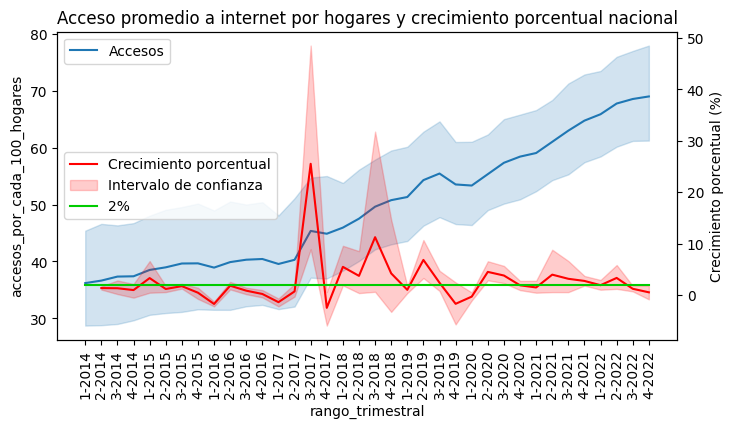

In [6]:
fig = plt.figure(figsize=(8,4), dpi=100)

#Graficamos la media nacional de acceso por hogares
sns.lineplot(
    data=penet_per100hog.reindex(index=penet_per100hog.index[::-1]),
    y='accesos_por_cada_100_hogares',
    x='rango_trimestral'
)
plt.xticks(rotation=90)
plt.legend(labels=['Accesos'], loc='upper left')
ax2 = plt.twinx()

#Graficamos el crecimiento porcentual de la media de acceso por hogares
sns.lineplot(
    ax=ax2,
    data=penet_per100hog.reindex(index=penet_per100hog.index[::-1]),
    y='kpi_1',
    x='rango_trimestral',
    color='r'
)
nn = penet_per100hog.groupby(by=['ano', 'trimestre', 'rango_trimestral'], as_index=False).mean(numeric_only=True)
percentage = (nn[nn['kpi_1']>=2].shape[0]/nn.shape[0])*100

ax2.set_ylabel('Crecimiento porcentual (%)')
ax2.plot(['1-2014', '4-2022'], [2,2], c='#00CC00')
ax2.legend(labels=['Crecimiento porcentual', 'Intervalo de confianza', f'2%'], loc='center left')

plt.title('Acceso promedio a internet por hogares y crecimiento porcentual nacional')
plt.savefig('kpiHogares.png')
plt.show()

### En argentina el acceso a internet en hogares va en aumento con el pasar del tiempo. Asimismo, los años de mayor crecimiento fueron los 2017 y 2018. Aquellos años dentro del periodo de la presidencia de Mauricio Macri (2015-2019) con la [consigna](https://www.lanacion.com.ar/tecnologia/que-es-el-plan-federal-de-internet-que-presento-hoy-mauricio-macri-nid1899595/) de mejorar el internet para los argentinos, conllevó a un crecimiento en el acceso a internet a nivel nacional. Asimismo, la meta planteadad de obtener un crecimiento de al menos un 2% del acceso cada 100 hogares se logro el 38% de la veces a nivel trimestral entre los años 2014-2022

### <strong>Penetración del Internet fijo por provincia (accesos por cada 100 habitantes)</strong>

Penetración del servicio de Internet fijo (métrica: población)

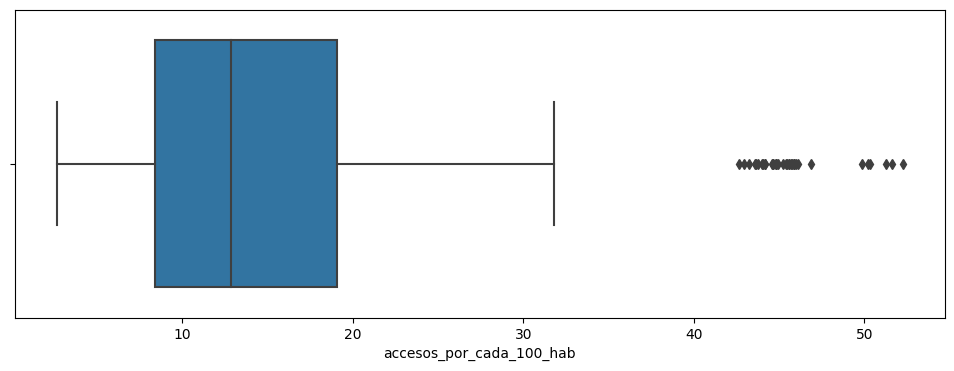

In [7]:
#Extraemos el dataset desde la api
respuesta_API_penet_per100hab = requests.get(
    'http://api.datosabiertos.enacom.gob.ar/api/v2/datastreams/PENET-DEL-INTER-FIJO-POR/data.ajson/?auth_key='+AUTH_KEY
)

if respuesta_API_penet_per100hab.status_code == 200:
  data = respuesta_API_penet_per100hab.text
  parse_json = json.loads(data)
  penet_per100hab = pd.read_json(json.dumps(parse_json['result']))    #Cargamos el dataset en una DataFrame
  penet_per100hab.columns = penet_per100hab.loc[0]                    #Definimos los nombres de columnas por la primera fila del dataset
  penet_per100hab.columns = list(map(lambda x: unidecode.unidecode(x.replace(' ', '_').lower()), penet_per100hab.columns))  #Cambiamos a minusculas y reemplazamos espacios por '_'
  penet_per100hab = penet_per100hab.drop(0)                           #Eliminamos la primera fila que contiene los nombres de columnas
  penet_per100hab.reset_index(drop=True, inplace=True)                #reseteamos los indices
else:
  penet_per100hab = pd.read_csv('penp100hab.csv')
  penet_per100hab.columns = list(map(lambda z: unidecode.unidecode(z.replace(' ', '_').lower()), penet_per100hab.columns))
  penet_per100hab.dropna(axis=1, inplace=True)
  penet_per100hab.reset_index(drop=True, inplace=True)

#Normalizamos los valores de la columna provincia, cambiamos a mayusculas
penet_per100hab['provincia'] = penet_per100hab['provincia'].apply(lambda string: string.upper())

#Creamos la columna rango trimestral para hacer los graficos
penet_per100hab['rango_trimestral'] = penet_per100hab['trimestre'] + '-' + penet_per100hab['ano']

#Cambiamos los tipos de datos a int
penet_per100hab['ano'] = penet_per100hab['ano'].apply(int)
penet_per100hab['trimestre'] = penet_per100hab['trimestre'].apply(int)
#####################################

#Limpiamos los datos de la columna accesos_por_cada_100_hab y cambiamos el tipo de daton a float
penet_per100hab['accesos_por_cada_100_hab'] = penet_per100hab['accesos_por_cada_100_hab'].apply(lambda string: float(string.replace(',','.')))

#Creamos la columna acceso previo  para cada provincia
penet_per100hab['accesos_previo'] = penet_per100hab['accesos_por_cada_100_hab'].shift(
    -len(penet_per100hab['provincia'].unique()),
)

#Calculamos el KPI (crecrimiento porcentual) de acceso para cada provincia con una frecuencia trimestral
penet_per100hab['kpi_1'] = ((penet_per100hab['accesos_por_cada_100_hab'] - penet_per100hab['accesos_previo'])/penet_per100hab['accesos_previo'])*100

#Graficamos un boxplot para evaluar outliers
plt.figure(figsize=(12,4), dpi=100)
sns.boxplot(data=penet_per100hab, x='accesos_por_cada_100_hab')

plt.show()

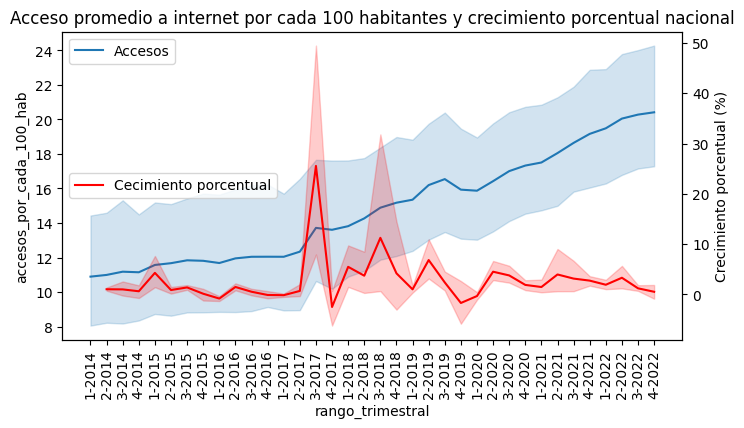

In [8]:
#Graficamos la media de acceso por cada 100 habitantes nacional
#y su correspondiente crecimiento porcentual
fig = plt.figure(figsize=(8,4), dpi=100)
sns.lineplot(
    data=penet_per100hab.reindex(index=penet_per100hab.index[::-1]),
    y='accesos_por_cada_100_hab',
    x='rango_trimestral'
)
plt.xticks(rotation=90)
plt.legend(labels=['Accesos'], loc='upper left')
ax2 = plt.twinx()
sns.lineplot(
    ax=ax2,
    data=penet_per100hab.reindex(index=penet_per100hab.index[::-1]),
    y='kpi_1',
    x='rango_trimestral',
    color='r'
)
ax2.set_ylabel('Crecimiento porcentual (%)')
ax2.legend(labels=['Cecimiento porcentual'], loc='center left')

plt.title('Acceso promedio a internet por cada 100 habitantes y crecimiento porcentual nacional')
plt.show()

### Esta vez no se planteo graficar tanto el crecimiento porcentual como el acceso por cada cien habitantes de manera particular, es decir, por provincia debido a la relacion de ambos datos, de hecho, podemos ver que que el aumento del acceso por cada 100 habitantes y el crecimiento porcetual siguen la misma forma que para la penetracion por cada 100 hogares.

### Al tener acceso a esta data y teniendo el numero de la poblacion por provincia podemos obtener el numero de habitantes con acceso a un conexión de internet fija.

In [9]:
#Tomamos un subdataset con la provincia y su poblacion
poblacion_porProv = listaxloc[['provincia', 'poblacion']].groupby('provincia', as_index=False).sum()

#Tomamos un subdataset con el acceso por cada 100 habitantes para el ultimo trimestre de 2022
acceso_cada100hab_2022 = penet_per100hab[(penet_per100hab['ano']==2022) & (penet_per100hab['trimestre']==4)]

#Mezclamos los dos ultimos dataframe
nroDehab_conAcceso_porProv = poblacion_porProv.merge(
    acceso_cada100hab_2022[['provincia', 'accesos_por_cada_100_hab']],
    on='provincia'
)

#Calculamos los accesos totales para cada provincia
nroDehab_conAcceso_porProv['hab_con_acceso'] =(nroDehab_conAcceso_porProv['poblacion'] * nroDehab_conAcceso_porProv['accesos_por_cada_100_hab'])/100

#Hacemos print del acceso a internet a nivel nacional
print(f"El número de accesos a internet para finales de año de 2022 fue: {int(nroDehab_conAcceso_porProv['hab_con_acceso'].sum())} habitantes\n\n\n")

El número de accesos a internet para finales de año de 2022 fue: 6305058 habitantes





### <strong>Acceso a Internet Fijo por rangos de velocidad de bajada y provincia</strong>

Número de accesos al servicio de Internet fijo por velocidad de bajada en cada provincia (trimestral)

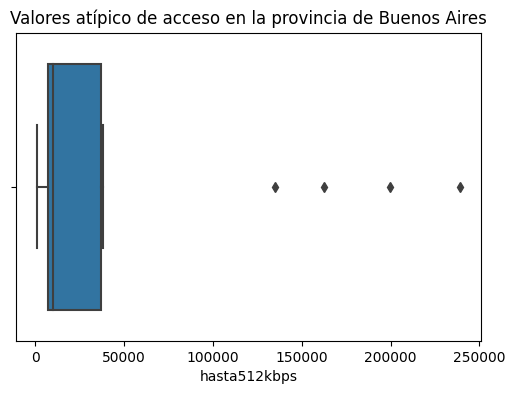

In [10]:
#Extraemos los datos desde la api
respuesta_API_acc_perVeloProv = requests.get(
    'http://api.datosabiertos.enacom.gob.ar/api/v2/datastreams/ACCES-A-INTER-FIJO-23248/data.ajson/?auth_key='+AUTH_KEY
)





if respuesta_API_acc_perVeloProv.status_code == 200:
  data = respuesta_API_acc_perVeloProv.text
  parse_json = json.loads(data)
  acc_perVeloProv = pd.read_json(json.dumps(parse_json['result']))    #Cargamos el dataset en una DataFrame
  acc_perVeloProv.columns = acc_perVeloProv.loc[0]              #Definimos los nombres de columnas por la primera fila del dataset
  acc_perVeloProv.columns = list(map(lambda x: x.replace(' ', '').lower(), acc_perVeloProv.columns))      #Cambiamos a minusculas y reemplazamos espacios por '_'
  acc_perVeloProv = acc_perVeloProv.drop(0)                     #Eliminamos la primera fila que contiene los nombres de columnas
  acc_perVeloProv.reset_index(drop=True, inplace=True)          #reseteamos los indices
else:
  acc_perVeloProv = pd.read_csv('acc_perVeloProv.csv')
  acc_perVeloProv.columns = list(map(lambda z: z.replace(' ', '').lower(), acc_perVeloProv.columns))
  acc_perVeloProv.dropna(axis=1, inplace=True)
  acc_perVeloProv.reset_index(drop=True, inplace=True)

# Normalizamos la columna provincia, cambiamos a mayuscula y reemplazamos CAPITAL FEDERAL por CABA
acc_perVeloProv['provincia'] = acc_perVeloProv['provincia'].apply(lambda string: unidecode.unidecode(string.upper()))
acc_perVeloProv.loc[acc_perVeloProv['provincia']=='CAPITAL FEDERAL', 'provincia'] = 'CABA'
#######################################################################

# Rellensamo los campos vacios de la columna 'otros' por ceros
# Esto se hizo así debido a que la suma total concordaba
acc_perVeloProv.loc[acc_perVeloProv['otros']=='', 'otros'] = '0'

#Creamos una columna con el rango trimestral
acc_perVeloProv['rango_trimestral'] = acc_perVeloProv['trimestre'] + '-' + acc_perVeloProv['año']

#Se hace un barrido por los rangos de velocidad y el punto '.'  es quitado para comvertir a entero
for column_name in acc_perVeloProv.columns[3:len( acc_perVeloProv.columns)-1]:
  try:
    acc_perVeloProv[column_name] = acc_perVeloProv[column_name].apply(lambda string: int(string.replace('.', '')))
  except Exception as e:
    print(e)
    print(column_name)
  pass

#Determinamos el acceso previo para velocidades mayores a 30mbps
acc_perVeloProv['accesos_previo_30m'] = acc_perVeloProv['+30mbps'].shift(
    -len(acc_perVeloProv['provincia'].unique()),
)

#Determinamos el acceso previo para velocidades hasta 512kbps
acc_perVeloProv['accesos_previo_512k'] = acc_perVeloProv['hasta512kbps'].shift(
    -len(acc_perVeloProv['provincia'].unique()),
)

#Determinamos el crecimiento porcentual de los accesos para los rangos de velocdad extremos
acc_perVeloProv['kpi_1_30m'] = ((acc_perVeloProv['+30mbps'] - acc_perVeloProv['accesos_previo_30m'])/acc_perVeloProv['accesos_previo_30m'])*100
acc_perVeloProv['kpi_1_-512k'] = ((acc_perVeloProv['hasta512kbps'] - acc_perVeloProv['accesos_previo_512k'])/acc_perVeloProv['accesos_previo_512k'])*100


plt.figure(figsize=(6,4), dpi=100)
sns.boxplot(
    data=acc_perVeloProv[acc_perVeloProv['provincia']=='BUENOS AIRES'],
    x='hasta512kbps'
)

plt.title('Valores atípico de acceso en la provincia de Buenos Aires')
plt.show()
acc_perVeloProv.to_csv('acc_perVeloProv.csv')
#acc_perVeloProv.groupby(by=['año', 'trimestre', 'rango_trimestral']).sum(numeric_only=True)


Teniendo en cuenta estos *outliers* graficaremos los accesos a los valores extremos de velocidad de bajada menores a 512kbps, sin tomar en cuenta la provincia de Buenos Aires.

In [11]:
#Queremos un poco de interactividad por lo tanto usamos un menu desplegable
dd = widgets.Dropdown(
    options=list(acc_perVeloProv['rango_trimestral'].unique()),
    value=list(acc_perVeloProv['rango_trimestral'].unique())[0],
    description='Trimestre',
)

#Definimos la función que se ejecutara cada vez que seleccionemos un item del dropdown
def plots_(column):
  plt.figure(figsize=(8,4), dpi=100)
  trimestre_value = acc_perVeloProv[acc_perVeloProv['rango_trimestral']==column]
  columns = ['hasta512kbps','+512kbps-1mbps','+1mbps-6mbps','+6mbps-10mbps','+10mbps-20mbps','+20mbps-30mbps','+30mbps', 'otros']
  ax = sns.barplot(
      data=trimestre_value[columns],
      errorbar=None,
      estimator=lambda x: (sum(x)/trimestre_value[columns].sum(numeric_only=True).sum())*100 #El estimador no sera la media la suma de accesos por tecnología entre el acceso total
  )
  ax.bar_label(ax.containers[0], fontsize=12, fmt='%1.2f%%')
  plt.title(f'Distribución % de los distintos rangos de velocidad\npara el trimestre {column}')
  plt.xlabel('Tecnología')
  plt.ylim(0, 100)
  plt.xticks(rotation=45)
  plt.savefig('velocidadesInTime.pdf')

  plt.show()

interact(plots_, column=dd)

interactive(children=(Dropdown(description='Trimestre', options=('4-2022', '3-2022', '2-2022', '1-2022', '4-20…

<function __main__.plots_(column)>

Esta vez hemos hecho la grafica interactiva y podemos ver la distribución de los rangos de velocidad y es apreciable que el acceso a internet a altas velocidades fue incrementando a medida que pasaba el tiempo, hasta dejar relegada a las bajas velocidades. Podemos ver que la actualización de la tecnología avanza rapidamente luego del 2017, esto lo verificaremos usando una serie temporal mas abajo.

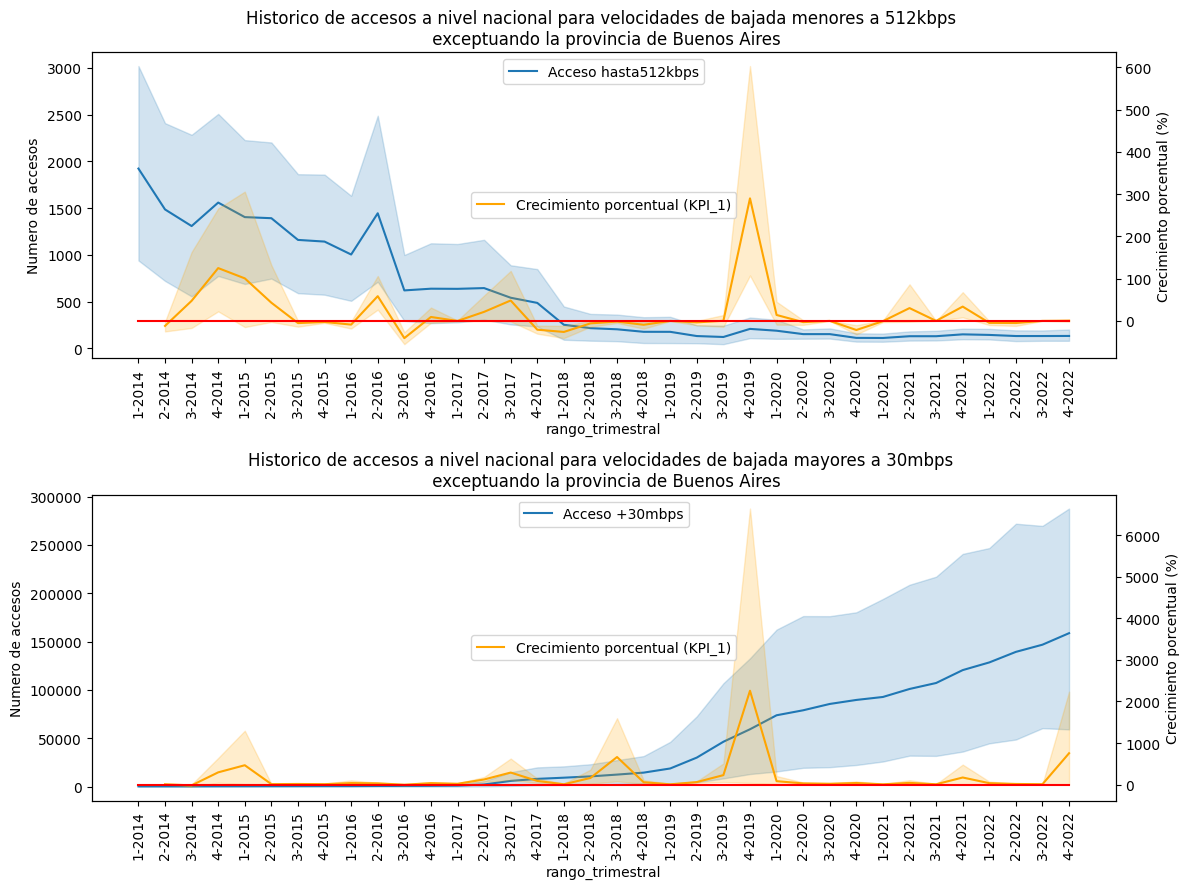

In [12]:
fig, axes = plt.subplots(2, figsize=(12,9), dpi=100)
columns = [('hasta512kbps', 'kpi_1_-512k'), ('+30mbps', 'kpi_1_30m')]
titles = [
    'Historico de accesos a nivel nacional para velocidades de bajada menores a 512kbps \n exceptuando la provincia de Buenos Aires',
    'Historico de accesos a nivel nacional para velocidades de bajada mayores a 30mbps \n exceptuando la provincia de Buenos Aires'
]
for i, col in enumerate(columns):
  sns.lineplot(
      ax=axes[i],
      data=acc_perVeloProv[acc_perVeloProv['provincia']!='BUENOS AIRES'].reindex(index=acc_perVeloProv.index[::-1]),
      y=col[0],
      x='rango_trimestral'
  )
  ax2 = plt.twinx(axes[i])
  sns.lineplot(
      ax=ax2,
      data=acc_perVeloProv[acc_perVeloProv['provincia']!='BUENOS AIRES'].reindex(index=acc_perVeloProv.index[::-1]),
      y=col[1],
      x='rango_trimestral',
      color='orange'
  )
  axes[i].tick_params(axis='x', rotation=90)
  plt.plot(['1-2014', '4-2022'], [0, 0], c='r')

  axes[i].legend(labels=['Acceso '+col[0]], loc='upper center')
  axes[i].set_ylabel('Numero de accesos')
  axes[i].set_title(titles[i])
  ax2.legend(labels=['Crecimiento porcentual (KPI_1)'], loc='center')
  ax2.set_ylabel('Crecimiento porcentual (%)')
  plt.savefig(str(i)+'.png')
fig.tight_layout()
plt.show()

*   **[Gráfica Superior]** Es observable que con el uso de nuevas tecnologías como lo es la fibra optica, capaz de manejar altas velocidades, a costos asequibles, el uso de velocidades de bajada inferiores a 512kbps a nivel nacional decrece con el tiempo llegando a quedar obsoletas.

*   **[Grafica inferior]** Es apreciable que el mejoramiento de la velocidad de internet conlleva a que los usuarios se actualicen y acepten el cambio, a partir del año 2017 se muestra un incremento de accesos a tecnologías de alta velocidad.

Debido a la amplia receptividad a planes de alta velocidad, se puede prescindir de las tecnologias de baja velocidad.

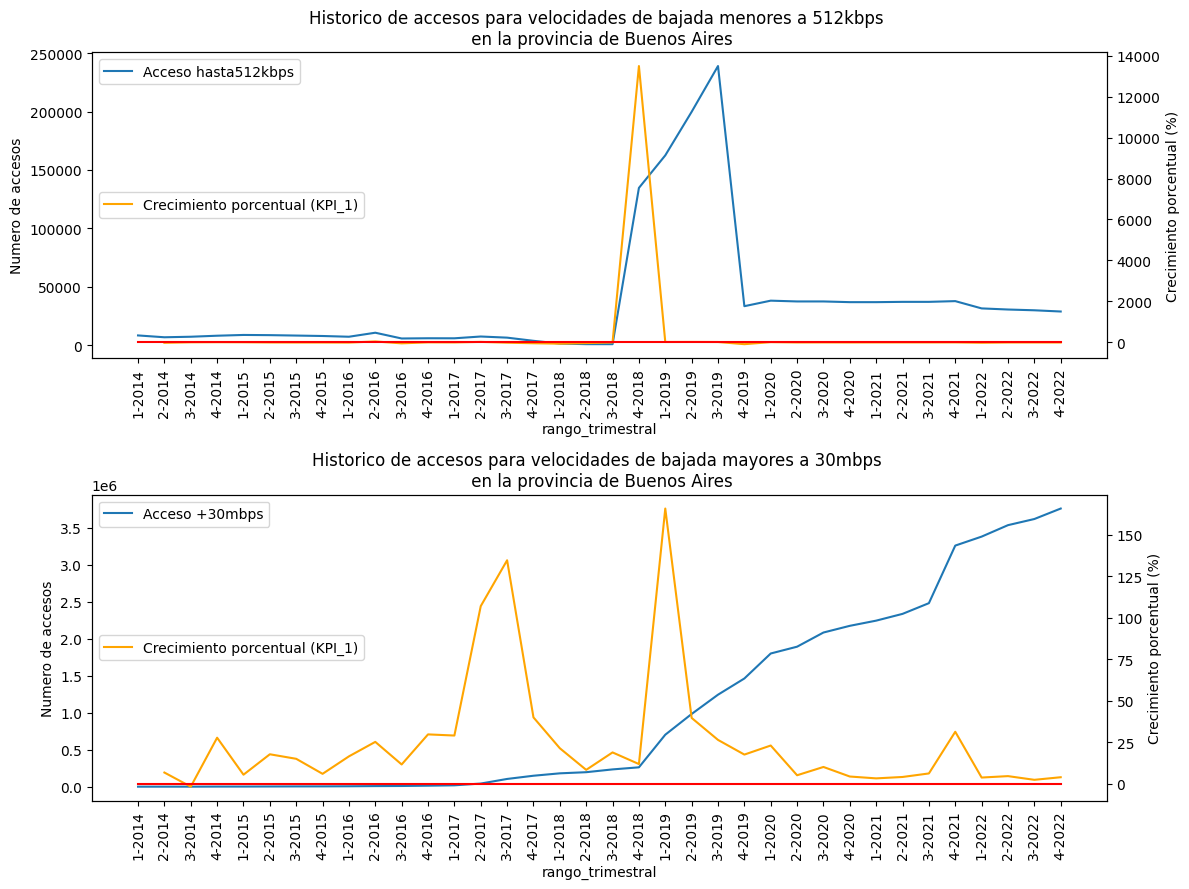

In [13]:
fig, axes = plt.subplots(2, figsize=(12,9), dpi=100)
columns = [('hasta512kbps', 'kpi_1_-512k'), ('+30mbps', 'kpi_1_30m')]
titles = [
    'Historico de accesos para velocidades de bajada menores a 512kbps \n en la provincia de Buenos Aires',
    'Historico de accesos para velocidades de bajada mayores a 30mbps \n en la provincia de Buenos Aires'
]
for i, col in enumerate(columns):
  sns.lineplot(
      ax=axes[i],
      data=acc_perVeloProv[acc_perVeloProv['provincia']=='BUENOS AIRES'].reindex(index=acc_perVeloProv.index[::-1]),
      y=col[0],
      x='rango_trimestral'
  )
  ax2 = plt.twinx(axes[i])
  sns.lineplot(
      ax=ax2,
      data=acc_perVeloProv[acc_perVeloProv['provincia']=='BUENOS AIRES'].reindex(index=acc_perVeloProv.index[::-1]),
      y=col[1],
      x='rango_trimestral',
      color='orange'
  )
  axes[i].tick_params(axis='x', rotation=90)
  plt.plot(['1-2014', '4-2022'], [0, 0], c='r')

  axes[i].legend(labels=['Acceso '+col[0]], loc='upper left')
  axes[i].set_ylabel('Numero de accesos')
  axes[i].set_title(titles[i])
  ax2.legend(labels=['Crecimiento porcentual (KPI_1)'], loc='center left')
  ax2.set_ylabel('Crecimiento porcentual (%)')

fig.tight_layout()
plt.show()

*   **[Gráfica superior]** Lo valores atipicos puede verse en esta gráfica debido a ello no se considera para el analisis general (nacional).

*   **[Grafica inferior]** al igual que el crecimiento a nivel nacional de acceso a internet de alta velocidad la provincia de Buenos Aires (la más habitada) también sigue la tendencia incremental observandose el aumento significativo a partir del año 2017

Esta velocidad es la media a nivel nacional tanto para internet fijo como para internet movil, antes solo hemos analizado la distribución de los rango de velocidad únicamente para internet fijo. La disminución de la velocidad de bajada es debido a que la velocidad del internet movil es muy baja.

### <strong>Accesos a Internet fijo por tecnología y localidad</strong>

Número de accesos al servicio de Internet fijo por tecnología en cada localidad declarada Categoría

In [14]:
def transformacion(x: str):
  x = str(x).replace('-', '')
  if '.' in str(x):
    x = x.split('.')
    if len(x[1])>1:
      x[1]+='0'
    else:
      x[1]+='00'
    return int(''.join(x))
  else:
    return int(x)

respuesta_API_accInterFijo_byLoc = requests.get(
    'http://api.datosabiertos.enacom.gob.ar/api/v2/datastreams/ACCES-A-INTER-FIJO-62463/data.ajson/?auth_key='+AUTH_KEY
)

if respuesta_API_accInterFijo_byLoc.status_code == 200:
  data = respuesta_API_accInterFijo_byLoc.text
  parse_json = json.loads(data)
  accInterFijo_byLoc = pd.read_json(json.dumps(parse_json['result']))
  accInterFijo_byLoc.columns = accInterFijo_byLoc.loc[0]
  accInterFijo_byLoc.columns = list(map(lambda x: unidecode.unidecode(x.replace(' ', '_').lower()), accInterFijo_byLoc.columns))
  accInterFijo_byLoc = accInterFijo_byLoc.drop(0)
  accInterFijo_byLoc = accInterFijo_byLoc.drop(columns=[''])
  accInterFijo_byLoc.reset_index(drop=True, inplace=True)
else:
  accInterFijo_byLoc = pd.read_csv('penp100hog.csv')
  accInterFijo_byLoc.columns = list(map(lambda z: unidecode.unidecode(z.replace(' ', '_').lower()), accInterFijo_byLoc.columns))
  accInterFijo_byLoc.dropna(axis=1, inplace=True)
  accInterFijo_byLoc.reset_index(drop=True, inplace=True)

accInterFijo_byLoc.drop(columns=['total_general'], inplace=True)
accInterFijo_byLoc.head()

,provincia,partido,localidad,link_indec,adsl,cablemodem,dial_up,fibra_optica,otros,satelital,wimax,wireless
0,BUENOS AIRES,25 de Mayo,25 de Mayo,6854100,874,4.54,- 0,3,- 0,852,- 0,706
1,BUENOS AIRES,25 de Mayo,Del Valle,6854020,181,- 0,- 0,- 0,10,1,- 0,- 0
2,BUENOS AIRES,25 de Mayo,Gobernador Ugarte,6854040,- 0,- 0,- 0,- 0,- 0,- 0,- 0,181
3,BUENOS AIRES,25 de Mayo,Norberto de la Riestra,6854060,- 0,782,- 0,6,167,- 0,- 0,327
4,BUENOS AIRES,25 de Mayo,Lucas Monteverde,6854050,- 0,- 0,- 0,- 0,- 0,- 0,- 0,6


La data numerica esta un poco sucia, aquellos numeros con un punto tal como 4.54 son en realidad 4540, es decir son unidades de mil.

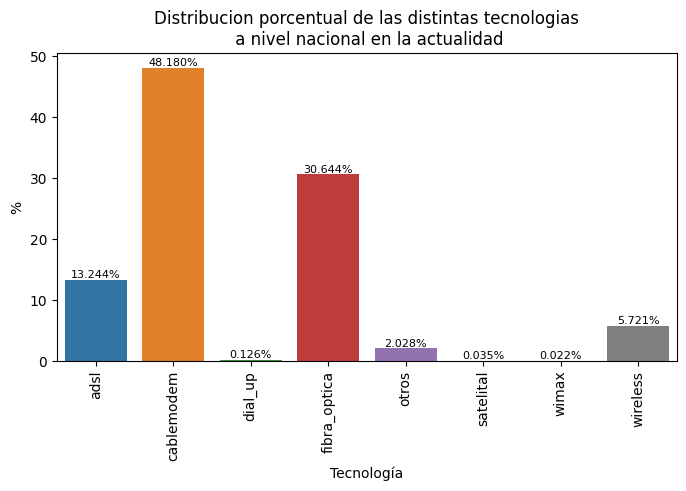

In [99]:
for column_name in accInterFijo_byLoc.columns[4:len(accInterFijo_byLoc.columns)]:
  accInterFijo_byLoc[column_name] = accInterFijo_byLoc[column_name].apply(lambda x: transformacion(x))
#accInterFijo_byLoc.groupby(by='provincia').sum()

#estos datos en power bi se pueden  colocar en una rosquilla interactiva con filtros por provincia año u trimestre

plt.figure(figsize=(8,4), dpi=100)
ax = sns.barplot(
    data=accInterFijo_byLoc.drop(columns=['provincia', 'partido', 'localidad', 'link_indec',]),
    errorbar=None,
    estimator=lambda x: (sum(x)/accInterFijo_byLoc.sum(numeric_only=True).sum())*100
)
ax.bar_label(ax.containers[0], fontsize=8, fmt='%1.3f%%')
plt.title('Distribucion porcentual de las distintas tecnologias\n a nivel nacional en la actualidad')
plt.xlabel('Tecnología')
plt.ylabel('%')

plt.xticks(rotation=90)
plt.show()


La fibra optica ha tenido un gran crecimiento en los ultimos años, ya que es la tecnología de acceso a internet mas rapida existente, la misma proyecta un crecimiento continuo qu dejara en algunos años relegadas (como se observa en el historico de rangos de velocidades trimestral) a las demas tecnologías si se desea alcanzar alto niveles de velocidad en internet en la mayoria de los hogares. En concordancia con lo datos en la web de [wikipedia](https://es.wikipedia.org/wiki/Internet_en_la_Argentina#Datos_generales).